In [31]:
# import pandas to handle data manipulation
import pandas as pd
# import numpy to handle array computations efficiently
import numpy as np
# import xgboost for data modelling
import xgboost as xgb
# import matplotlib to plot graphs
import matplotlib.pyplot as plt
import seaborn as sns
# import from sklearn to complement data modelling
from sklearn.preprocessing import OrdinalEncoder,StandardScaler

In [32]:
# load in data from csv
df1=pd.read_csv('train.csv')
df2=pd.read_csv('test.csv')

In [33]:
print(df1.columns)
# remove Name,Ticket,PassengerId
# need to check if cabin alphabet is important
# check first letter of name/ surname for further features?

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [34]:
# used Data Wrangler to check if there is any missing data
incl_columns=['Survived','Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']

# filter columns required for model
df_train=df1[incl_columns]
# fill in for Sex
df_train=df_train.fillna("NA")
print(df_train.dtypes)

# used Data Wrangler to check if there is any missing data on test data - now filled with NA
df_test=df2[incl_columns[1:]]
df_test=df_test.fillna("NA")
print(df_test.dtypes)

Survived      int64
Pclass        int64
Sex          object
Age          object
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
dtype: object
Pclass       int64
Sex         object
Age         object
SibSp        int64
Parch        int64
Fare        object
Embarked    object
dtype: object


In [35]:
#for each feature, rank the categories in the order of increasing loss
cat_col=["Sex","Embarked"]

# Age, Embarked has NA
# Age needs to be replaced by mean
# Sex, Embarked needs ordinal encoding
# Sex, Embarked sorted by Survived for ordinal encoding

# Ordinal Encoder for Sex and Embarked
df_train_ord=df_train.copy()
sorted_cat_list=list()
for col in cat_col:
    # create pivot table for each feature, target Survived, and sort the table by the target
    sorted_cat=df_train.loc[df_train.index,[col,"Survived"]].reset_index().pivot_table(index=col,values="Survived",aggfunc=np.mean).sort_values(by="Survived").index
    sorted_cat_list.append(list(sorted_cat))

#create Ordinal Encoder with the sorted categories for each features
oe=OrdinalEncoder(categories=sorted_cat_list,handle_unknown="use_encoded_value",unknown_value=np.nan)
#fit on train set
oe.fit(df_train_ord[cat_col])

#transform the categorical features and save as dataframe
df_train_ord_temp=oe.transform(df_train_ord[cat_col])
df_train_ord_temp=pd.DataFrame(df_train_ord_temp,columns=cat_col,index=df_train.index)

#update original dataframe
df_train_ord.update(df_train_ord_temp)
# convert the categorical features to float (for training in xgboost model)
for col in cat_col:
    df_train_ord[col]=df_train_ord[col].astype(float)

# replace NA with mean for Age (implying NA does not contribute to prediction)
NA_replacement=df_train_ord.loc[df_train_ord["Age"]!="NA","Age"].mean()
df_train_ord["Age"]=df_train_ord["Age"].replace("NA",NA_replacement)

C:\Users\User\AppData\Local\Temp\ipykernel_13028\189990891.py:14: FutureWarning: The provided callable <function mean at 0x000001A5AB72CA60> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  sorted_cat=df_train.loc[df_train.index,[col,"Survived"]].reset_index().pivot_table(index=col,values="Survived",aggfunc=np.mean).sort_values(by="Survived").index
C:\Users\User\AppData\Local\Temp\ipykernel_13028\189990891.py:14: FutureWarning: The provided callable <function mean at 0x000001A5AB72CA60> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  sorted_cat=df_train.loc[df_train.index,[col,"Survived"]].reset_index().pivot_table(index=col,values="Survived",aggfunc=np.mean).sort_values(by="Survived").index
C:\Users\User\AppData\Local\Temp\ipykernel

In [36]:
# create new column with first letter of cabin/ NA if value is missing 
cabin=df1["Cabin"]
cabin.replace(np.nan,"NA",inplace=True)

# extract cabin type
def extract_cabin(cabin):
    if cabin[:2]=="NA":
        return "NA"
    else:
        return cabin[0]

cabin=cabin.apply(extract_cabin)

# create new columns in train_ord with new feature
df_train_ord["Cabin"]=cabin
sorted_cabin=df_train_ord.loc[df_train_ord.index,["Cabin","Survived"]].reset_index().pivot_table(index="Cabin",values="Survived",aggfunc=np.mean).sort_values(by="Survived").index
sorted_cabin=sorted_cabin.tolist()

#create Ordinal Encoder with the sorted categories for each features,set unknown to -1, setting it to a category with lowest loss( only for )
oe2=OrdinalEncoder(categories=[sorted_cabin],handle_unknown="use_encoded_value",unknown_value=np.nan)
#fit on train set
oe2.fit(df_train_ord[["Cabin"]])

# #transform the categorical features and save as dataframe
df_train_ord_temp=oe2.transform(df_train_ord[["Cabin"]])
df_train_ord_temp=pd.DataFrame(df_train_ord_temp,columns=["Cabin"],index=df_train.index)

#update original dataframe
df_train_ord.update(df_train_ord_temp)
df_train_ord["Cabin"]=df_train_ord["Cabin"].astype(float)

C:\Users\User\AppData\Local\Temp\ipykernel_13028\505261208.py:16: FutureWarning: The provided callable <function mean at 0x000001A5AB72CA60> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  sorted_cabin=df_train_ord.loc[df_train_ord.index,["Cabin","Survived"]].reset_index().pivot_table(index="Cabin",values="Survived",aggfunc=np.mean).sort_values(by="Survived").index


Text(0.5, 1.0, 'Kendall Tau')

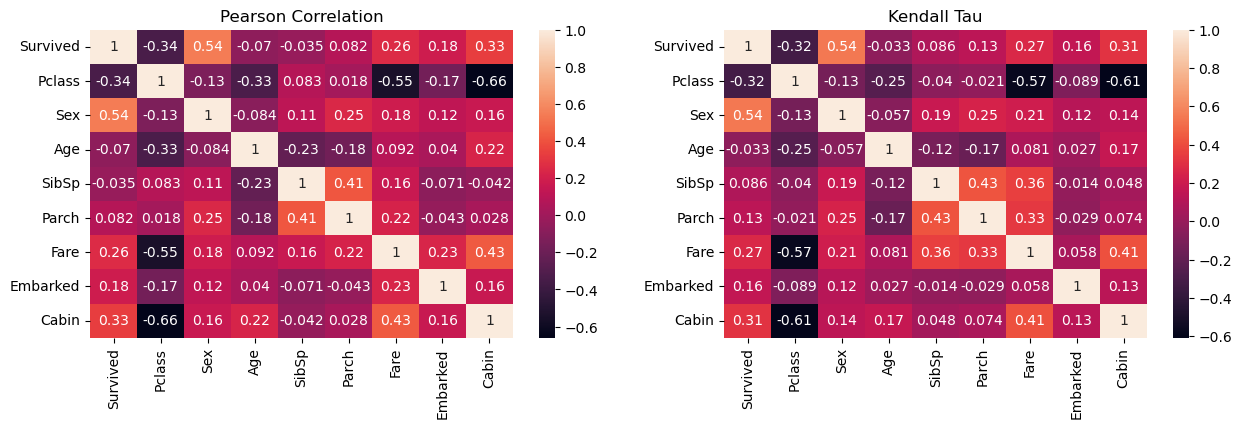

In [37]:
# data exploration
# plot heatmap
plt.figure(figsize=(15, 4))
# correlation heatmap
plt.subplot(1,2,1)
pearson_corr=df_train_ord.corr(method="pearson")
sns.heatmap(pearson_corr,annot=True).set_title("Pearson Correlation")


plt.subplot(1,2,2)
kendall_corr=df_train_ord.corr(method="kendall")
sns.heatmap(kendall_corr,annot=True).set_title("Kendall Tau")
# afraid that pearson correlationn cannot capture non-linear relationships well
# used kendall to complement

Text(0.5, 1.0, 'Pclass vs. Survival Rate')

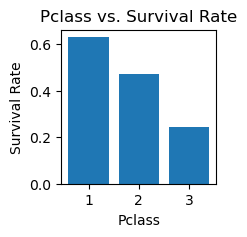

In [38]:
# Pclass vs Survival
plt.figure(figsize=(2, 2))
y=df_train_ord.groupby("Pclass")["Survived"].mean()
x=y.index
plt.bar(x,y)
plt.xlabel("Pclass")
plt.ylabel("Survival Rate")
plt.title("Pclass vs. Survival Rate")
# just dump Pclass into model as there is difference of Survival between Pclass (negative correlation)

Text(0.5, 1.0, 'Sex vs. Survival Rate')

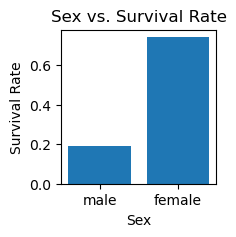

In [39]:
# Sex vs Survival
plt.figure(figsize=(2, 2))
y=df_train_ord.groupby("Sex")["Survived"].mean()
x=sorted_cat_list[0]
plt.bar(x,y)
plt.xlabel("Sex")
plt.ylabel("Survival Rate")
plt.title("Sex vs. Survival Rate")
# just dump into model, significant difference between male and female Survival

Text(0.5, 1.0, 'Age vs. Survival Rate')

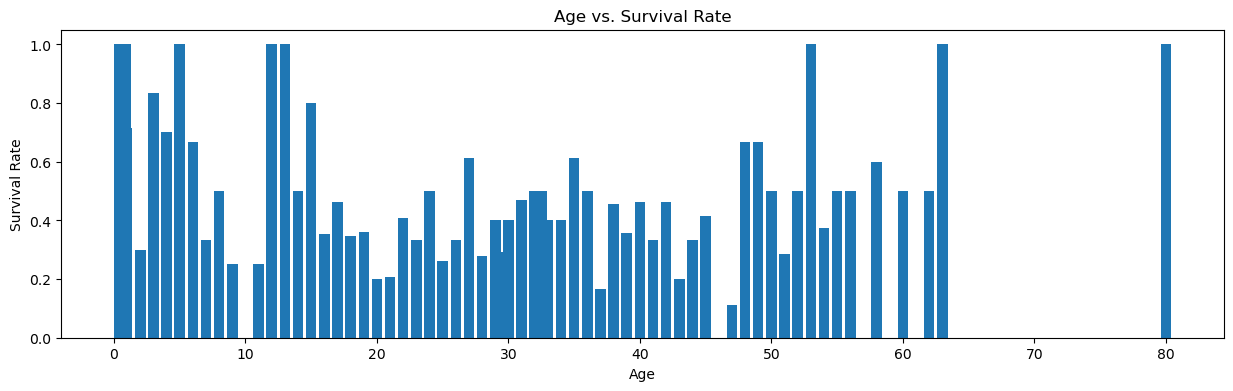

In [40]:
# Age vs Survival
plt.figure(figsize=(15,4))
y=df_train_ord.groupby("Age")["Survived"].mean()
x=y.index
plt.bar(x,y)
plt.xlabel("Age")
plt.ylabel("Survival Rate")
plt.title("Age vs. Survival Rate")
# notice that the age above 50 has higher Survival
# age below 15 also has higher Survival
# split <15, 15 to 50, >50

Text(0.5, 1.0, 'Age distribution')

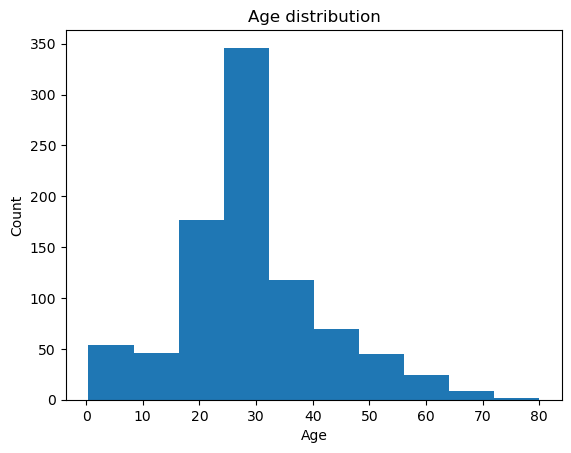

In [41]:
# Age distribution
plt.hist(df_train_ord["Age"])
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Age distribution")

C:\Users\User\AppData\Local\Temp\ipykernel_13028\818105237.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  y=df_train_ord.groupby("Age_bin")["Survived"].mean()
C:\Users\User\AppData\Local\Temp\ipykernel_13028\818105237.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_train_ord.groupby("Age_bin")["Survived"].mean()


Age_bin
16.000    0.550000
20.000    0.341772
24.000    0.367347
28.000    0.352941
29.699    0.301508
32.500    0.437500
38.000    0.449438
47.000    0.329545
80.000    0.415730
Name: Survived, dtype: float64

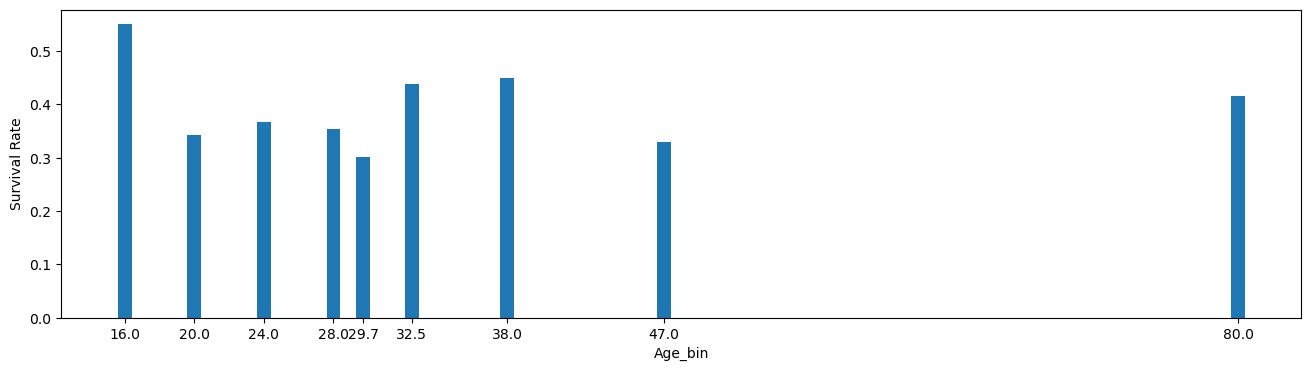

In [42]:
# split the Age observations into 10 bins of equal proportions 
df_train_ord["Age_bin"]=pd.qcut(df_train_ord["Age"],10,duplicates="drop").apply(lambda x: x.right)

# plot the survival rate vs. Age_bin
plt.figure(figsize=(16,4))
y=df_train_ord.groupby("Age_bin")["Survived"].mean()
# sort x values since we know the Age_bin observations in the groupby is done from young to old
x=df_train_ord["Age_bin"].unique().sort_values()
plt.bar(x,y)
plt.xlabel("Age_bin")
plt.ylabel("Survival Rate")
plt.xticks(x)
# split using the qcut (split into 10% of total observations for each bin)

# plot the survival rate for each Age_bin
df_train_ord.groupby("Age_bin")["Survived"].mean()

([<matplotlib.axis.XTick at 0x1a5b37ec370>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(8, 0, '8')])

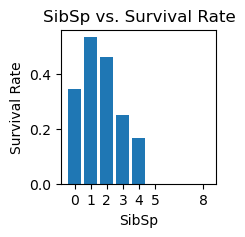

In [43]:
# SibSp vs Survival
plt.figure(figsize=(2, 2))
y=df_train_ord.groupby("SibSp")["Survived"].mean()
x=y.index
plt.bar(x,y)
plt.xlabel("SibSp")
plt.ylabel("Survival Rate")
plt.title("SibSp vs. Survival Rate")
plt.xticks(x)
# split 0,1-2,4, significantly higher survival rate for 2-3 siblings (are they children since adult siblings rarely interact together anymore?)

Text(0.5, 1.0, 'SibSp distribution')

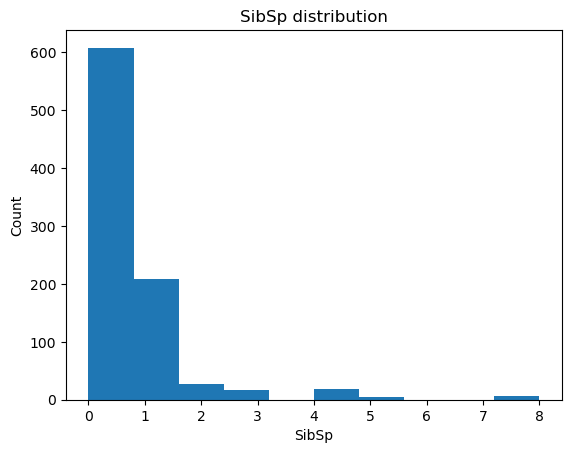

In [44]:
# Age distribution
plt.hist(df_train_ord["SibSp"])
plt.xlabel("SibSp")
plt.ylabel("Count")
plt.title("SibSp distribution")
# note that many come alone
# 1 and 2 has slightly less observations than 0
# combine observations >2 into one bin (avoid having too many categories)

C:\Users\User\AppData\Local\Temp\ipykernel_13028\2837868316.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  y=df_train_ord.groupby("Fare_bin")["Survived"].mean()


Text(0.5, 1.0, 'Fare_bin vs. Survival Rate')

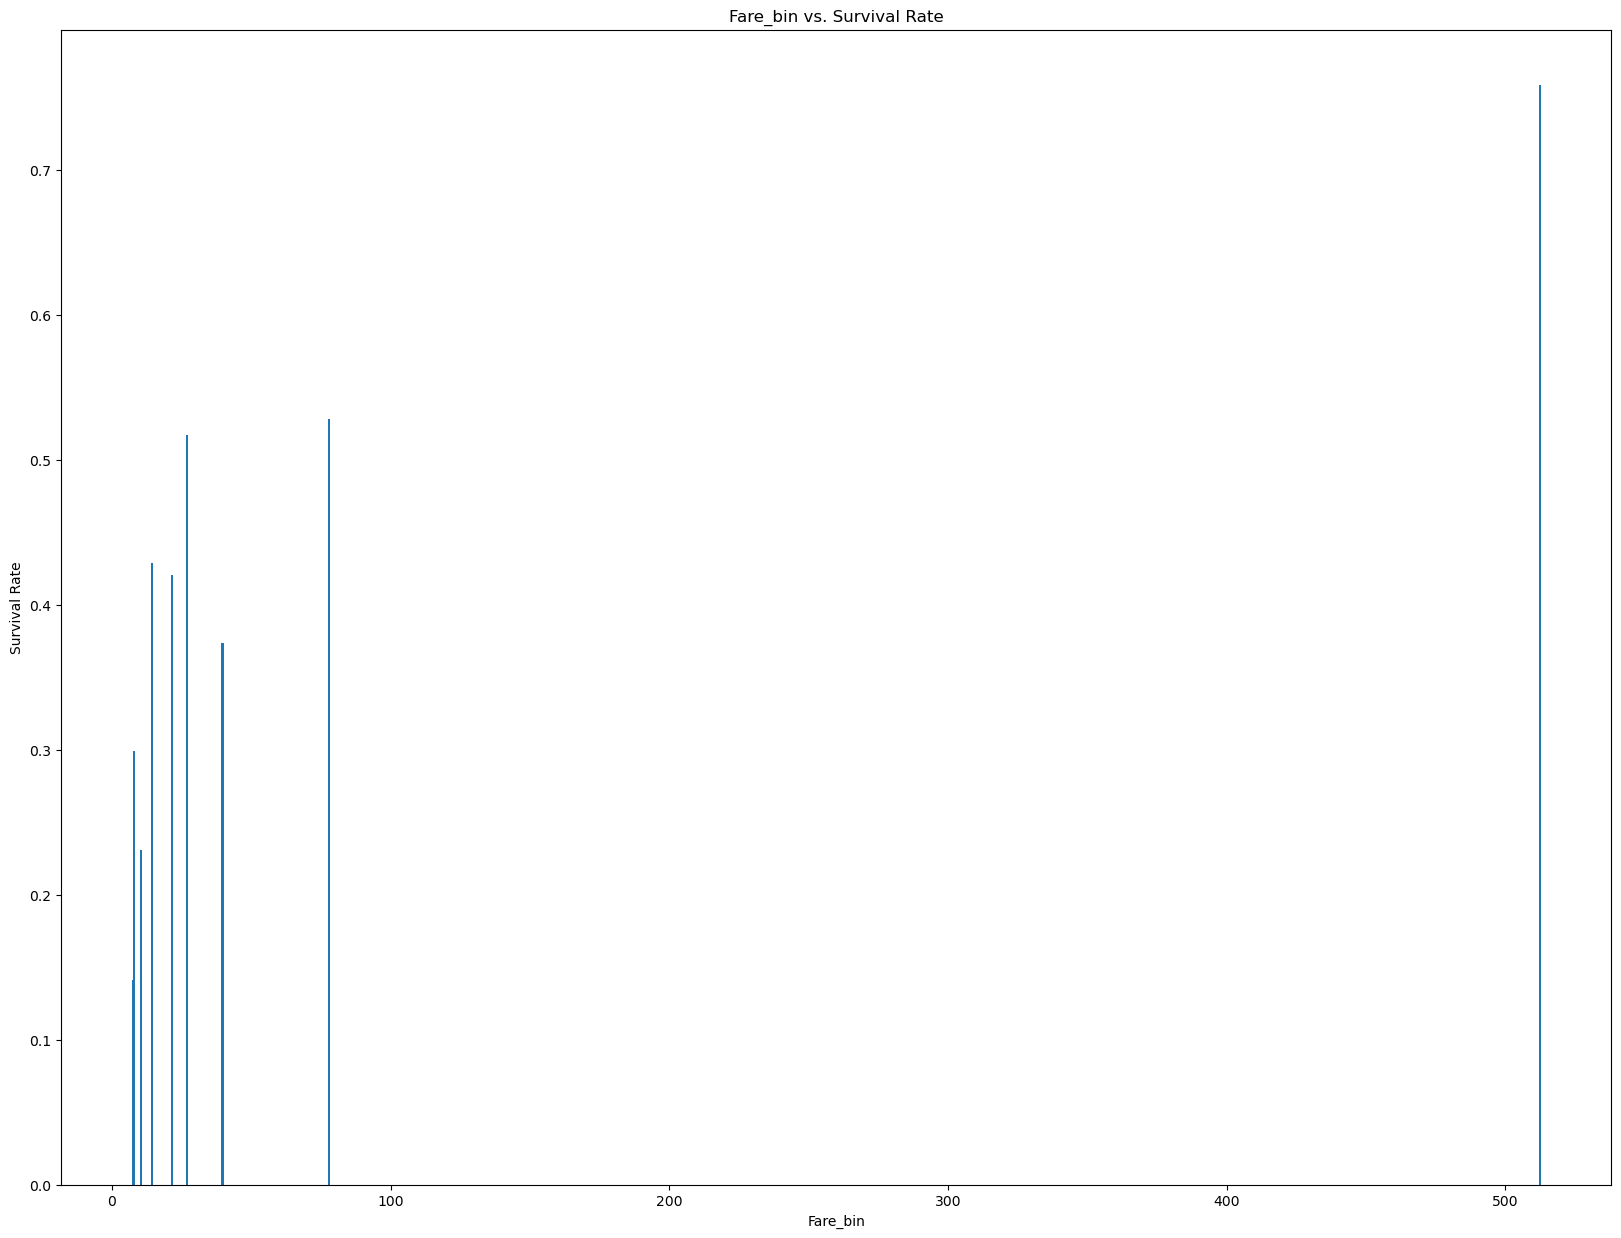

In [45]:
# split Fare into bins of equal proportions (10 bins)
df_train_ord["Fare_bin"]=pd.qcut(df_train_ord["Fare"],10,duplicates="drop").apply(lambda x: x.right)
plt.figure(figsize=(20,15))
y=df_train_ord.groupby("Fare_bin")["Survived"].mean()

# sort since the bins are ranked from low to high Fare in y
x=df_train_ord["Fare_bin"].unique().sort_values()
plt.bar(x,y)
plt.xlabel("Fare_bin")
plt.ylabel("Survival Rate")
plt.title("Fare_bin vs. Survival Rate")
# <100,>100

Text(0.5, 1.0, 'Fare_bin distribution')

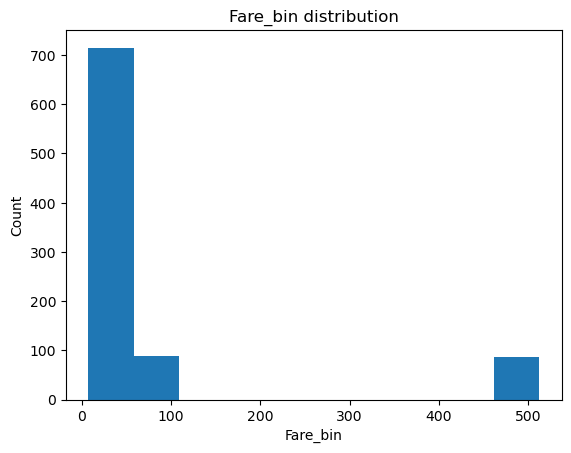

In [46]:
# Fare distribution
plt.hist(df_train_ord["Fare_bin"])
plt.xlabel("Fare_bin")
plt.ylabel("Count")
plt.title("Fare_bin distribution")

([<matplotlib.axis.XTick at 0x1a5b75ff4f0>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6')])

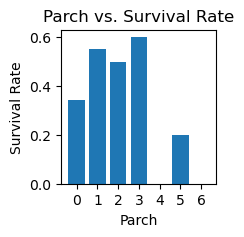

In [47]:
# Parch vs Survival
plt.figure(figsize=(2, 2))
y=df_train_ord.groupby("Parch")["Survived"].mean()
x=y.index
plt.bar(x,y)
plt.xlabel("Parch")
plt.ylabel("Survival Rate")
plt.title("Parch vs. Survival Rate")
plt.xticks(x)
# 1,2,3 have higher survival rate
# split into 0, 1-3, >=4

Text(0.5, 1.0, 'Embarked distribution')

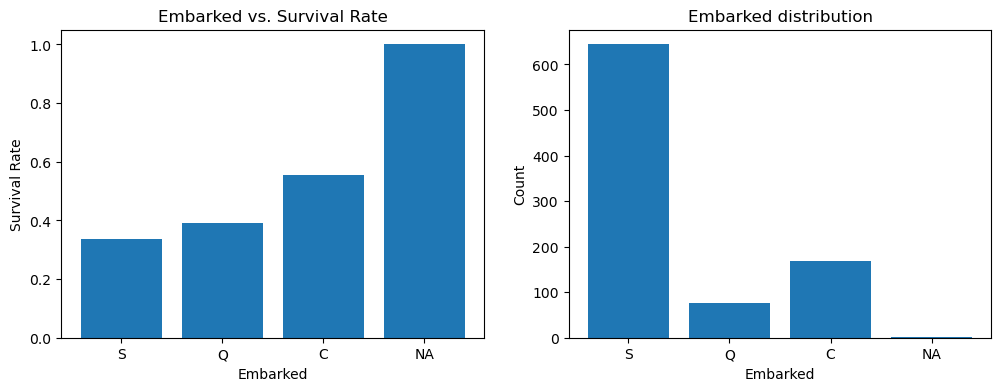

In [48]:
# Embarked vs. Survival

plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
y=df_train_ord.groupby("Embarked")["Survived"].mean()
x=sorted_cat_list[1]
plt.bar(x,y)
plt.xlabel("Embarked")
plt.ylabel("Survival Rate")
plt.title("Embarked vs. Survival Rate")
plt.xticks(x)
# 1,2,3 have higher survival rate

# plt.subplots_adjust(wspace=2)
plt.subplot(1,2,2)
y=df_train_ord.groupby("Embarked")["Survived"].count()
plt.bar(x,y)
plt.xlabel("Embarked")
plt.ylabel("Count")
plt.title("Embarked distribution")
# just dump into model

<BarContainer object of 9 artists>

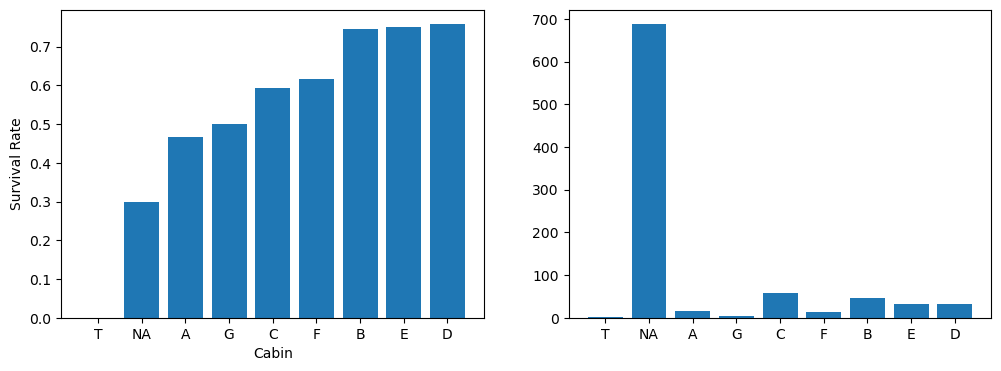

In [49]:
# Cabin vs. Survival
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
y=df_train_ord.groupby("Cabin")["Survived"].mean()

# list of cabins sorted against survival rate
x=sorted_cabin
plt.bar(x,y)
plt.xlabel("Cabin")
plt.ylabel("Survival Rate")
plt.xticks(x)
# B,E,D have higher survival rate

# plt.subplots_adjust(wspace=2)
plt.subplot(1,2,2)
y=df_train_ord.groupby("Cabin")["Survived"].count()
plt.bar(x,y)
# BED much higher but less people,
# NA much lower? 
# AGCF quite similar?
# incl Cabin into model directly after ordinal encoding